In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from venn import venn
import copy
import random
%matplotlib inline
import seaborn as sns
from pylab import *
from matplotlib.colors import colorConverter

import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])


from Bio import SeqIO
AA_symbols = {'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'}

In [2]:
# Two datasets from HeLa cells:
fnam1 = 'hsa_Geiger_2012_HeLa.csv'
fnam2 = 'hsa_Nagaraj_2011.csv'

df1 = pd.read_csv(fnam1, sep='\t', skiprows=[0])
df2 = pd.read_csv(fnam2, sep='\t', skiprows=[0])

In [3]:
# Extract all the UniProt IDs:
P_id = list(df1['!ProteinIdentifier'].values)
P_id.extend(list(df2['!ProteinIdentifier'].values))
print(len(P_id))
P_id = list(set(P_id))
print(len(P_id))
# Print the IDs to a file,
# then download a fasta file with all their sequences:
with open('all_protein_IDs.txt', 'w') as fh:
    print(' '.join(P_id), file=fh)

20857
14605


In [4]:
# Fasta file with all the protein sequences
# containing abundance information:
seq_file = 'all_proteins.fasta'

id2seq = dict()
for record in SeqIO.parse(seq_file, "fasta"):
    ID = record.id.split('|')[1]
    seq = str(record.seq)
    id2seq[ID] = seq

In [5]:
### Non unresolved amino acids are so few that they are neglegible ###
# Removing unresolved amino acids:
for ID, seq in id2seq.items():
    non_ca = [AA for AA in seq if AA not in AA_symbols]
    ca = [AA for AA in seq if AA in AA_symbols]
    if len(non_ca) > 0:
        pass
        #print(ID)
        #print(non_ca)
        #print(seq)
    id2seq[ID] = ''.join(ca)

In [6]:
AA_abundance = dict()
for AA_i, df_i in enumerate([df1, df2]):
    # Extract usefull information:
    df_abd_info = df_i.loc[:,['!ProteinIdentifier', '!Abundance[ppm]', '!ProteinSize', '!ProteinName', '!Pathway']]
    df_abd_info['Seq'] = [''] * len(df_abd_info)
    
    # Insert sequence information:
    prot_ids = df_abd_info['!ProteinIdentifier'].values
    for ID in prot_ids:
        if ID in id2seq:
            seq = id2seq[ID]
        else:
            seq = None
        df_abd_info.loc[df_abd_info['!ProteinIdentifier'] == ID, 'Seq'] = seq

    # Remove rows with no sequence data:
    df_abd_info = df_abd_info.loc[~(df_abd_info['Seq'].values == None)]

    # Renormalize ppm values:
    norm = sum(df_abd_info['!Abundance[ppm]'].values) / 1e6
    df_abd_info.loc[:, '!Abundance[ppm]'] = df_abd_info['!Abundance[ppm]'] * norm

    # Tally the abundance of each amino acid:
    AA_abundance[AA_i] = {AA: 0 for AA in AA_symbols}
    for ppm, seq in zip(df_abd_info['!Abundance[ppm]'], df_abd_info['Seq']):
        for AA in seq:
            AA_abundance[AA_i][AA] += ppm

    # Normalize the amino acid abundance to frequencies:
    ts = sum([v for v in AA_abundance[AA_i].values()])
    for k in AA_abundance[AA_i].keys():
        AA_abundance[AA_i][k] = AA_abundance[AA_i][k] / ts * 100

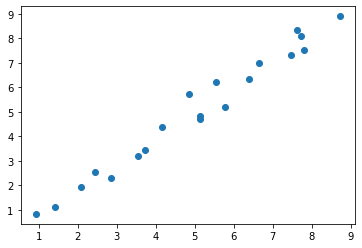

In [7]:
# Make comparisons between the two datasets:
AAs = list(AA_symbols)
x = [AA_abundance[0][AA] for AA in AAs]
y = [AA_abundance[1][AA] for AA in AAs]
# Plot it:
plt.scatter(x,y)

In [8]:
# Print amino acid frequencies:
AA_list = []
abd_list = []
for k, v in AA_abundance[0].items():
    AA_list.append(k)
    abd_list.append(v)
print('\t'.join(AA_list))
print('\t'.join(list(map(str, abd_list))))

F	Y	K	I	T	V	P	R	G	N	Q	C	E	D	W	M	S	H	A	L
3.5400902600192596	2.8633775943760575	7.71788059786008	5.132941279536273	5.13659495173733	6.657652169784657	4.858186481737166	5.7787966448172225	7.463707354066949	3.7322397078378686	4.157017702770572	1.4092404269735272	7.620460379429243	5.5564643766742705	0.9236601061398463	2.452326874795476	6.392700434153051	2.072777971221846	7.800325313503667	8.733559372565644
